In [1]:
# This version is without chatGPT summarization just cosine 

In [27]:

import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
import tensorflow as t
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Unzipping csv file

In [3]:

uploaded_zip = '/home/claney/EclipsePlatform/eclipse_platform.zip'
extract_dir = '/home/claney/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
full_df = pd.read_csv(csv_file)

In [4]:
full_df.fillna(0,inplace=True)

# Spliting testing and training

In [5]:
length=len(full_df)
split_index=int(.8*length)
df=full_df.iloc[:split_index] #df=training set


# Creating isDuplicate column

In [6]:
def is_duplicate(val):
    return 1 if val !=0.0 else 0
df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))

print(df['isDuplicate'])

0        0
1        0
2        0
3        0
4        0
        ..
68119    0
68120    0
68121    0
68122    0
68123    0
Name: isDuplicate, Length: 68124, dtype: int64


/tmp/ipykernel_268298/1537637410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))


isDuplicate
0    56126
1    11998
Name: count, dtype: int64


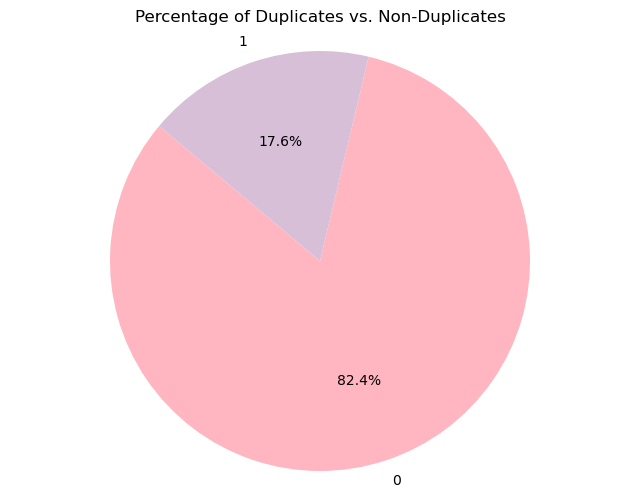

In [7]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'isDuplicate' is the column indicating duplicates
duplicate_counts = df['isDuplicate'].value_counts()

# Check the contents of duplicate_counts
print(duplicate_counts)

# Create a list of labels matching the length of duplicate_counts
# Ensure the labels match the values in the 'isDuplicate' column
labels = duplicate_counts.index.tolist()

# Define colors (length should match number of unique values in 'isDuplicate')
colors = ['#FFB6C1', '#D8BFD8'][:len(labels)]

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(duplicate_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Duplicates vs. Non-Duplicates')
plt.axis('equal')
plt.show()


# Preprocessing

In [8]:
df['Description'] = df['Description'].astype(str).fillna('')

/tmp/ipykernel_268298/77102330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].astype(str).fillna('')


In [9]:
#creating freeform textual data column
df['full_text_data']=df['Description']+df['Title']
print(df['full_text_data'])
df['full_text_data']=df['full_text_data'].fillna('')

0        - Setup a project that contains a *.gif resour...
1        Opening repository resource always open the de...
2        KM (10/2/2001 5:55:18 PM); \tThis PR about the...
3        - become synchronized with some project in a r...
4        For getting/setting the managed state of a res...
                               ...                        
68119    Build ID: 3.3 (I am not sure what You mean by ...
68120    There are several NPEs within the UI session t...
68121    I20080501-0100; ; Now that were using the coll...
68122    Created attachment 98318; screenshot; ; I20080...
68123    Build ID: M20080221-1800; ; Steps To Reproduce...
Name: full_text_data, Length: 68124, dtype: object


/tmp/ipykernel_268298/3345744263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['Description']+df['Title']
/tmp/ipykernel_268298/3345744263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['full_text_data'].fillna('')


In [10]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['full_text_data'])

# K-Means Clustering

/home/claney/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Fit 2 clusters


/home/claney/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


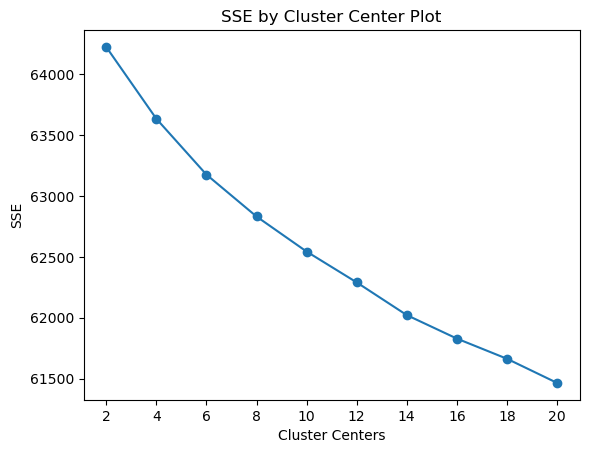

In [11]:


# Step 2: Finding the optimal number of clusters using the Elbow Method
#The elbow method is a graphical method for finding the optimal K value in a k-means clustering algorithm. 

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        print(f'Fit {k} clusters')

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    plt.show()

find_optimal_clusters(X, 20)

# Based on the plot, choose the optimal number of clusters
optimal_k = 10



In [12]:
# Step 3: Apply KMeans Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X)


df['Cluster'] = clusters

# Displaying the clustered bug reports
print(df)


       Issue_id Priority Component  Duplicated_issue  \
0             1       P3      Team               0.0   
1             2       P5      Team               0.0   
2             3       P5      Team               0.0   
3             4       P5      Team               0.0   
4             5       P3      Team               0.0   
...         ...      ...       ...               ...   
68119    229777       P3        UI               0.0   
68120    229779       P3        UI               0.0   
68121    229782       P3        UI               0.0   
68122    229789       P3        UI               0.0   
68123    229792       P3      Team               0.0   

                                                   Title  \
0        Usability issue with external editors (1GE6IRL)   
1      Opening repository resources doesnt honor type...   
2              Sync does not indicate deletion (1GIEN83)   
3      need better error message if catching up over ...   
4      ISharingManager shar

/tmp/ipykernel_268298/3811319238.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = clusters


In [13]:
# Split the DataFrame based on the 'Cluster' column
grouped = df.groupby('Cluster')

# Create individual DataFrames 
for cluster in grouped.groups.keys():
    vars()[f'cluster_{cluster}_df'] = grouped.get_group(cluster)
print(cluster_0_df)

       Issue_id Priority Component  Duplicated_issue  \
145         146       P3      Team             170.0   
162         163       P3      Team               0.0   
169         170       P3      Team               0.0   
233         234       P3      Team               0.0   
235         236       P5      Team               0.0   
...         ...      ...       ...               ...   
68079    229473       P3        UI               0.0   
68093    229587       P3     Debug               0.0   
68108    229712       P3        UI          229473.0   
68114    229748       P3      Team               0.0   
68116    229765       P3        UI               0.0   

                                                   Title  \
145         UnknownHostException: Repositories (1GEWRWG)   
162                exception when disconnected (1GF7QCA)   
169    InterruptedIOException: connection failure (1G...   
233                                NPE in sync (1GJ4W10)   
235           Exceptions st

# Functions 

In [14]:
def getDuplicateBugIDS(threshold_value,topic_x_df): 
    import torch
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    # Encode sentences and store the embeddings in the DataFrame
    topic_x_df['embeddings'] = topic_x_df['full_text_data'].apply(lambda x: model.encode(x, convert_to_tensor=True))
    # Convert embeddings to a tensor
    embeddings = torch.stack(topic_x_df['embeddings'].tolist())
    # Calculate cosine similarity
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    numpy_array = cosine_scores.numpy()
    # Reshape the NumPy array into a matrix
    similarity_Matrix= numpy_array.reshape(cosine_scores.shape)
    similarity_Matrix= np.round(similarity_Matrix, decimals=4)
    # Function to filter rows based on condition
    def filter_matrix(matrix, threshold):
        filtered_matrix = []
        for row in matrix:
            if np.any((row > threshold) & (row < 1)): #<1 to igorne the sim. with itself 
                filtered_matrix.append(row)
        return np.array(filtered_matrix)
    # Filtering the matrix
    filtered_matrix = filter_matrix(similarity_Matrix, threshold_value)
    n = 0 #to iterate through
    topic_x_df['Experimental_Duplicate_ID'] = np.nan  #intailly sets everything to null
    while n < filtered_matrix.shape[0]:  # number of rows do this process to each row 
        matrix = filtered_matrix[n]
        def find_position(matrix):  # finds position (index) of bug all other bugs are comparing to
            result = np.where(matrix == 1.0)
            return result[0][0]  # Extract the first index directly
    
        def get_duplicate_ids_index(matrix):  # finds index where there are most similar bugs to the bug at find_position
            condition = np.logical_and(matrix > threshold_value, matrix < 1)
            indices = np.argwhere(condition)
            return indices
        def get_duplicate_ids(matrix_indexs_of_duplicates):
            duplicate_ids = ""
            for row in matrix_indexs_of_duplicates:
                for element in row:
                    specific_row = topic_x_df.iloc[element]
                    duplicate_ids = duplicate_ids + " " + str(specific_row['Issue_id'])
            return duplicate_ids
        index_in_df = find_position(matrix)  # index of selected bug
        specific_row = topic_x_df.iloc[index_in_df]  # selects bug row in dataframe
        duplicateIDs_index_in_df = get_duplicate_ids_index(matrix)  # index of duplicate bugs
        topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
        n += 1  # to go through each row in the matrix
    return topic_x_df['Experimental_Duplicate_ID']

In [15]:
def accuracy(topic_x_df):
    #a match is considered if there are any matching values in exp_ids and dup_ids 
       # Split the IDs by spaces and strip whitespace
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches
    num_matches = matches.sum()
    accuracy=num_matches/len(topic_x_df)
    return accuracy

In [16]:
def precision(topic_x_df):
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches which is when the experiment and actual match aka true positive
    truePositive = matches.sum()
    #falsePositive is when the experimental duplicate id has a number but the actual one doesn't
    falsePositives = ((topic_x_df['Duplicated_issue'] == 0) & (topic_x_df['Experimental_Duplicate_ID'] != 0)).sum()
    precision= truePositive/(truePositive+falsePositives)
    return precision
    

In [17]:
def recall(topic_x_df):
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches which is when the experiment and actual match aka true positive
    truePositive = matches.sum()

    # Convert columns to sets
    experimental_set = set(topic_x_df['Experimental_Duplicate_ID'])
    actual_set = set(topic_x_df['Duplicated_issue'])

    # Identify False Negatives
    falseNegatives = actual_set - experimental_set
    falseNegativesCount=len(list(falseNegatives))
    recall=truePositive/(truePositive+falseNegativesCount)
    return recall

In [18]:
def f1(topic_x_df):
    recallVal=recall(topic_x_df)
    precisionVal=precision(topic_x_df)
    f1=2*((recallVal*precisionVal)/(precisionVal+recallVal))
    return f1

In [19]:
def experimentalisDuplicate(topic_x_df): #creates column for experimental binary isDuplciates
    def is_duplicate(val):
        return 1 if val !=(0.0 or 0) else 0
    topic_x_df['isExperimentalDuplicate'] = topic_x_df['Experimental_Duplicate_ID'].apply(lambda x: is_duplicate(x))
    return topic_x_df['isExperimentalDuplicate']

In [20]:
def binaryAccuracy(topic_x_df): #see if the ones and zeros match, different from other acuracy becuase that one can have only one element mathc and it count ex bug 1 has ids 1234 and 8472 it should still count as a duplciate to bug 2 with 1234 0889 
    matches=topic_x_df['isExperimentalDuplicate']==topic_x_df['isDuplicate']
    num_matches=matches.sum()
    accuracy=num_matches/len(topic_x_df['isExperimentalDuplicate'])
    return accuracy

# Comparing cosine similaries in clusters 

In [31]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

cluster_dfs = [cluster_0_df, cluster_1_df, cluster_2_df, cluster_3_df, cluster_4_df, cluster_5_df, cluster_6_df, cluster_7_df, cluster_8_df, cluster_9_df]
# Initialize lists to store the results
accuracy_values = []
binary_accuracy_values = []
recall_values = []
precision_values = []
f1_values = []
for x in range(10):
    df = cluster_dfs[x]

    df['Experimental_Duplicate_ID'] = getDuplicateBugIDS(0.95, df)
    accuracyVal = accuracy(df) * 100
    accuracy_values.append(accuracyVal)
    print(f"Accuracy for cluster {x} for matching id is %{accuracyVal:.2f}")

    experimentalisDuplicate(df)
    binaryAccuracyVal = binaryAccuracy(df) * 100
    binary_accuracy_values.append(binaryAccuracyVal)
    print(f"Accuracy for cluster {x} for duplicate or not is %{binaryAccuracyVal:.2f}")

    recallVal = recall(df) * 100
    recall_values.append(recallVal)
    print(f"Recall for cluster {x} is %{recallVal:.2f}")

    precisionVal = precision(df) * 100
    precision_values.append(precisionVal)
    print(f"Precision for cluster {x} is %{precisionVal:.2f}")

    f1Val = f1(df) * 100
    f1_values.append(f1Val)
    print(f"F1 score for cluster {x} is %{f1Val:.2f}")


Accuracy for cluster 0 for matching id is %71.26
Accuracy for cluster 0 for duplicate or not is %71.33
Recall for cluster 0 is %78.67
Precision for cluster 0 is %99.71
F1 score for cluster 0 is %87.95
Accuracy for cluster 1 for matching id is %76.14
Accuracy for cluster 1 for duplicate or not is %76.17
Recall for cluster 1 is %81.53
Precision for cluster 1 is %99.96
F1 score for cluster 1 is %89.81
Accuracy for cluster 2 for matching id is %76.54
Accuracy for cluster 2 for duplicate or not is %76.54
Recall for cluster 2 is %81.68
Precision for cluster 2 is %99.89
F1 score for cluster 2 is %89.87
Accuracy for cluster 3 for matching id is %85.68
Accuracy for cluster 3 for duplicate or not is %85.68
Recall for cluster 3 is %88.04
Precision for cluster 3 is %100.00
F1 score for cluster 3 is %93.64
Accuracy for cluster 4 for matching id is %81.42
Accuracy for cluster 4 for duplicate or not is %81.42
Recall for cluster 4 is %84.71
Precision for cluster 4 is %99.93
F1 score for cluster 4 is %

In [22]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Your code here


In [33]:
import statistics 
print(statistics.mean(accuracy_values))
print(statistics.mean(binary_accuracy_values))
print(statistics.mean(recall_values))
print(statistics.mean(precision_values))
print(statistics.mean(f1_values))

80.66052934293211
80.68163182969509
84.87540194913721
99.92059270829546
91.74743574460457
